# Bag of words model
Final Project for NLP

In [74]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\isaac\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [103]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
import itertools
from collections import Counter

## Loading data and preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

"small_data.pickle" is a preprocessed dataset with reviews having greater than 2 "useful" tagging.

In [3]:
idA = {1:'American (Traditional)', 2:'Italian',3:'Mexican',4:'Chinese',5:'American (New)',6:'Japanese', 0:'Other'}
idB = {1:'Nightlife', 2:'Fast Food', 3:'Breakfast & Brunch', 4:'Coffee & Tea', 5:'Cafes', 0:'Other'}
df = pd.read_pickle("small_data.pickle")

In [27]:
df.shape

(144748, 7)

In [28]:
df.head()

,typeA,typeB,useful,cool,funny,review,stars
business_id,,,,,,,
frCxZS7lPhEnQRJ3UY6m7A,3,5,9,9,0,Dude.\n\nI love this place. It's walking dista...,5
n5jTCFF6LqNIAz6Jx5-3tw,4,2,2,0,1,Not worth the money. First time I came here & ...,2
PvyUmuJtpSYbkIaMQ0Fz2A,1,3,2,1,1,Love their chicken and waffle! The service was...,4
yVgNu6ZTTMbx69vOtdyHfg,1,3,3,0,0,WAAAAAYYYYY too expensive for the quality of ...,1
3lRXNifVJDgqylwaQEHvGw,1,2,3,0,0,This place was such a disappointment...even tr...,1


### Some utility functions to visualize the data

In [4]:
#plot pie charts to visualize the composition of the restaurants
def pie_chart(df):
    """draw pie chart to analysis the category variable
    :parameter
        df: DataFrame"""
    star_count = []
    for i in [1,2,3,4,5]:
        star_count.append(sum(df['stars'] == i))
        print(i, 'star:%.2f' %(star_count[-1]/df.shape[0]*100))
    
    plt.figure(figsize=(5,5))
    plt.pie(star_count, labels=[1,2,3,4,5])
    plt.show()

    typeA_count = []
    for i in [0,1,2,3,4,5,6]:
        typeA_count.append(sum(df['typeA'] == i))
        print(idA[i], 'typeA:%.2f' %(typeA_count[-1]/df.shape[0]*100))
    
    plt.figure(figsize=(5,5))
    plt.pie(typeA_count, labels=[idA[x] for x in [0,1,2,3,4,5,6]])
    plt.show()

    typeB_count = []
    for i in [0,1,2,3,4,5]:
        typeB_count.append(sum(df['typeB'] == i))
        print(idB[i], 'typeB:%.2f' %(typeB_count[-1]/df.shape[0]*100))
    
    plt.figure(figsize=(5,5))
    plt.pie(typeB_count, labels=[idB[x] for x in [0,1,2,3,4,5]])
    plt.show()

In [5]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
def sentence_tokenizer(s):
    """sentence tokenizer --modified from EDA version
    :parameter 
        s: String 
    :return
        tokenized_s: String"""
    s = s.lower()
    tokenized_s = nltk.word_tokenize(s)
    english_stopwords = set(stopwords.words('english'))
    tokenized_s = [w for w in tokenized_s if w not in english_stopwords if w.isalpha()]
    tokenized_s = " ".join(tokenized_s)
    return tokenized_s

The star categories are relatively balanced, luckily. There are a lot more American food restaurants than other types. Nightlife restaurants consist of more than half of the entire popoluation.

1 star:16.61
2 star:13.37
3 star:14.69
4 star:26.13
5 star:29.21


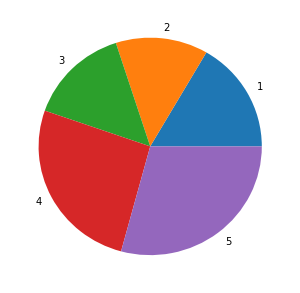

Other typeA:0.00
American (Traditional) typeA:28.85
Italian typeA:9.24
Mexican typeA:13.61
Chinese typeA:3.07
American (New) typeA:41.63
Japanese typeA:3.61


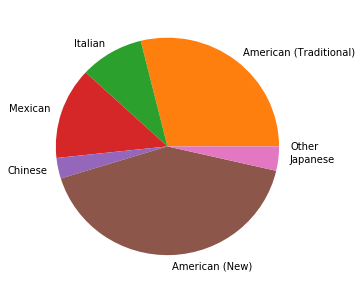

Other typeB:0.00
Nightlife typeB:57.24
Fast Food typeB:7.55
Breakfast & Brunch typeB:26.26
Coffee & Tea typeB:1.30
Cafes typeB:7.65


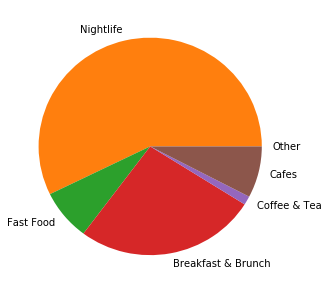

In [36]:
pie_chart(df)

In [46]:
review = df['review']
y = df['stars']

In [22]:
%%time
X = []
for i in tqdm(range(len(review))):
    X.append(sentence_tokenizer(review[i]))

100%|█████████████████████████████████████████████████████████████████████████| 144748/144748 [23:52<00:00, 101.02it/s]


Wall time: 23min 52s


In [56]:
#if you have this csv file already saved to the local drive
processed_df = pd.read_csv('processed_small_all.csv', encoding='utf-8', dtype={'review': str, 'typeA': int, 'typeB': int, 'star': int})
X = processed_df['review']

In [24]:
processed_df = pd.DataFrame({'review':X,'star':y})
processed_df.to_csv('processed_small.csv')

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Bag of words model

### Count Vectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [132]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(analyzer='word', max_features=5000, min_df=0.01, max_df=0.95, ngram_range=(1,2))  #can use n_gram, see document
X_train_features_count = count_vectorizer.fit_transform(X_train)
X_train_features_count = X_train_features_count.toarray()
X_test_features_count = count_vectorizer.transform(X_test)
X_test_features_count = X_test_features_count.toarray()

In [133]:
%%time
from sklearn.ensemble import RandomForestClassifier
forest_count = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=42) 
forest_count = forest_count.fit( X_train_features_count, y_train )

Wall time: 59.8 s


### Hashing Vectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html

Using Hashing vectorizer will dramatically extend the training time, therefore, it will not be considered here.

In [79]:
from sklearn.feature_extraction.text import HashingVectorizer
hashing_vectorizer = HashingVectorizer(analyzer='word', ngram_range=(1,2))
X_train_features_hash = hashing_vectorizer.fit_transform(X_train)
X_test_features_hash = hashing_vectorizer.transform(X_test)

### Tfidf Vectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_features=5000, min_df=0.01, max_df=0.95, ngram_range=(1,2))  #can use n_gram, see document
X_train_features_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_features_tfidf = X_train_features_tfidf.toarray()
X_test_features_tfidf = tfidf_vectorizer.transform(X_test)
X_test_features_tfidf = X_test_features_tfidf.toarray()

In [135]:
%%time
forest_tfidf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=42) 
forest_tfidf = forest_tfidf.fit( X_train_features_tfidf, y_train )

Wall time: 1min 2s


## TruncatedSVD after tfidf
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD<br>
TruncatedSVD is basically an implementation of LSA

In [137]:
from sklearn.decomposition import TruncatedSVD
truncatedsvd = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=5, random_state=9527)
X_train_features_lsa_tf = truncatedsvd.fit_transform(X_train_features_tfidf)
X_test_features_lsa_tf = truncatedsvd.transform(X_test_features_tfidf)

In [138]:
%%time
forest_lsa_tf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
forest_lsa_tf = forest_lsa.fit(X_train_features_lsa_tf, y_train)

Wall time: 39.5 s


## TruncatedSVD after countvectorizer

In [139]:
truncatedsvd = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=5, random_state=9527)
X_train_features_lsa_cnt = truncatedsvd.fit_transform(X_train_features_count)
X_test_features_lsa_cnt = truncatedsvd.transform(X_test_features_count)

In [140]:
%%time
forest_lsa_cnt = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
forest_lsa_cnt = forest_lsa_cnt.fit(X_train_features_lsa_cnt, y_train)

Wall time: 39.5 s


## Test and evalutaion

Need to choose a metric

In [141]:
model_cnt = forest_count
model_tfidf = forest_tfidf
model_lsa_tf = forest_lsa_tf
model_lsa_cnt = forest_lsa_cnt

In [142]:
y_pred_cnt = model_cnt.predict(X_test_features_count)
y_pred_tf = model_tfidf.predict(X_test_features_tfidf)
y_pred_lsa_tf = model_lsa_tf.predict(X_test_features_lsa_tf)
y_pred_lsa_cnt = model_lsa_cnt.predict(X_test_features_lsa_cnt)

#### Count vectorizer

F1 score 0.746149038091095
Accuracy 0.7599309153713298
Confusion: Matrix 
 [[2133   91   28   64   53]
 [ 373 1125  103  194  104]
 [ 170  115 1243  529  167]
 [  74   22   58 2870  723]
 [  45   11    9  542 3629]]


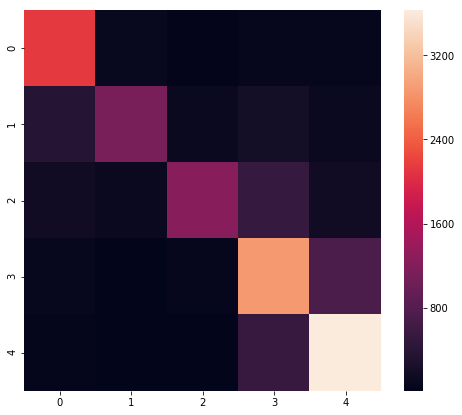

In [145]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
print('F1 score',f1_score(y_test, y_pred_cnt, average='macro'))
print('Accuracy', accuracy_score(y_test, y_pred_cnt))
print('Confusion: Matrix \n', confusion_matrix(y_test, y_pred_cnt))

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test, y_pred_cnt))
plt.show()

#### Tfidf vectorizer

F1 score 0.745670099971646
Accuracy 0.7602763385146805
Confusion: Matrix 
 [[2123  101   26   69   50]
 [ 378 1109  109  201  102]
 [ 156  105 1250  542  171]
 [  58   25   60 2839  765]
 [  45    7   11  489 3684]]


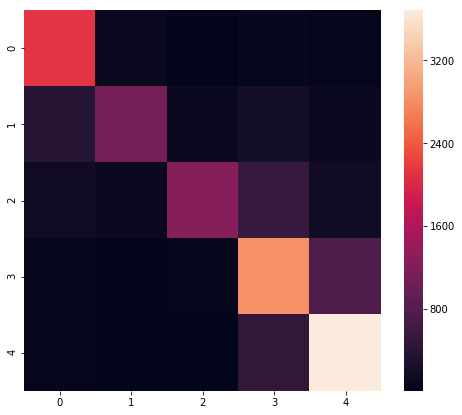

In [146]:
print('F1 score',f1_score(y_test, y_pred_tf, average='macro'))
print('Accuracy', accuracy_score(y_test, y_pred_tf))
print('Confusion: Matrix \n', confusion_matrix(y_test, y_pred_tf))

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test, y_pred_tf))
plt.show()

#### Count vectorizer followed by LSA

F1 score 0.7111607399084929
Accuracy 0.7252504317789292
Confusion: Matrix 
 [[2023   74   24  125  123]
 [ 362 1035   61  283  158]
 [ 188   86 1144  574  232]
 [ 127   38   57 2769  756]
 [ 104   14   18  573 3527]]


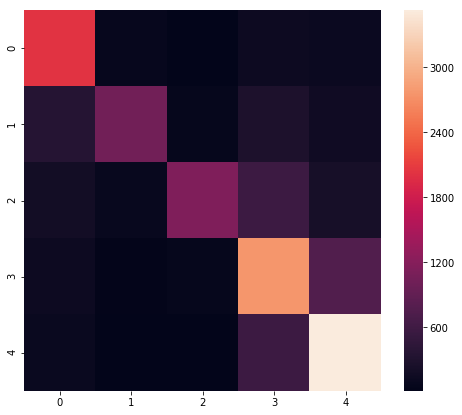

In [147]:
print('F1 score',f1_score(y_test, y_pred_lsa_cnt, average='macro'))
print('Accuracy', accuracy_score(y_test, y_pred_lsa_cnt))
print('Confusion: Matrix \n', confusion_matrix(y_test, y_pred_lsa_cnt))

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test, y_pred_lsa_cnt))
plt.show()

#### Tfidf vectorizer followed by LSA

F1 score 0.7275990105355991
Accuracy 0.743419689119171
Confusion: Matrix 
 [[2090  112   33   78   56]
 [ 372 1094   76  245  112]
 [ 184  123 1178  570  169]
 [  78   45   72 2796  756]
 [  68   16   19  530 3603]]


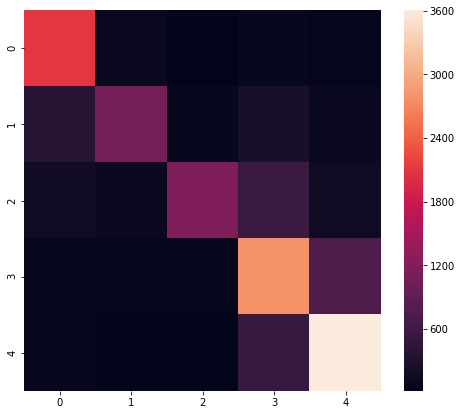

In [148]:
print('F1 score',f1_score(y_test, y_pred_lsa_tf, average='macro'))
print('Accuracy', accuracy_score(y_test, y_pred_lsa_tf))
print('Confusion: Matrix \n', confusion_matrix(y_test, y_pred_lsa_tf))

plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test, y_pred_lsa_tf))
plt.show()

1. Do min_df and max_df help?
2. Does using both word and bigram help?
   Only using the bigram does not work as well. Accu = 0.71. Using both word and bigram, Accu = 0.76, Using just the words Accu = 0.76
3. Does tfidf help?
4. Diagnose what is wrong (where inccorect prediction happens)
5. train model with one category and predict another
6. Multinomial naive bayes does not work well.

# Train a model on one category and predict another category

In [149]:
typeA = df['typeA']
typeB = df['typeB']

processed_df = pd.DataFrame({'review':X,'star':y,'typeA':typeA,'typeB':typeB})
processed_df.to_csv('processes_small_all.csv')

First consider the typeA categories. Use American food to train the model.
Based on the first part, it seems that all the vectorizer work comparably well. Just pick the tfidf which shows slightly higher accuracy to evaluate this case.

In [49]:
full_model = Pipeline([('vectorizer',TfidfVectorizer(analyzer='word', max_features=5000, min_df=0.01, max_df=0.95, ngram_range=(1,2))),
                       ('forest', RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=42))])

In [24]:
#take only one category to train the model
american = processed_df[processed_df['typeA'] == 5]
X_typeA = american['review'].values.astype('U')
y_typeA = american['star']

X_train_typeA, X_test_typeA , y_train_typeA, y_test_typeA = train_test_split(X_typeA, y_typeA, test_size=0.1, random_state=42)

model_american = full_model
model_american.fit(X_train_typeA, y_train_typeA)
y_pred_typeA = model_american.predict(X_test_typeA)
print('F1 score',f1_score(y_test_typeA, y_pred_typeA, average='macro'))
print('Accuracy', accuracy_score(y_test_typeA, y_pred_typeA))
print('Confusion: Matrix \n', confusion_matrix(y_test_typeA, y_pred_typeA))

F1 score 0.7458404925885064
Accuracy 0.758878194490541
Confusion: Matrix 
 [[ 758   34   21   29   29]
 [ 123  436   49   97   41]
 [  56   28  487  202   71]
 [  20    7   22 1277  378]
 [  29    2    3  212 1615]]


In [61]:
#apply this model to other category
def model_tester(trained_model, X, y_true, visualization=False):
    y_pred = trained_model.predict(X.values.astype('U')) #ensure the reviews are unicode strings. This could be an issue when reading data from csv
    print('F1 score',f1_score(y_true, y_pred, average='macro'))
    print('Accuracy', accuracy_score(y_true, y_pred))
    print('Confusion: Matrix \n', confusion_matrix(y_true, y_pred))
    
    if visualization == True:
        cm = confusion_matrix(y_true, y_pred)
        cm = cm/ cm.astype(np.float).sum(axis=1)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm)
        plt.show()

F1 score 0.4514358101046459
Accuracy 0.5269090170593014
Confusion: Matrix 
 [[2695  344  110  232  260]
 [ 958  480  354  629  311]
 [ 303  241  415 1295  550]
 [ 139   58  127 2255 2029]
 [ 131   31   30 1186 4533]]


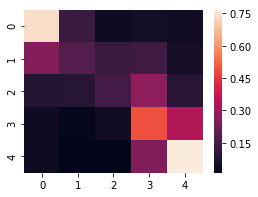

In [40]:
americanOld = processed_df[processed_df['typeA'] == 1]
americanNew = processed_df[processed_df['typeA'] == 5]
chinese = processed_df[processed_df['typeA'] == 4]
mexican = processed_df[processed_df['typeA'] == 3]
italian = processed_df[processed_df['typeA'] == 2]
japanese = processed_df[processed_df['typeA'] == 6]
model_tester(model_american, mexican['review'], mexican['star'], visualization=True)

In [58]:
#take one category from typeB
night = processed_df[processed_df['typeB'] == 1]
X_typeB = night['review'].values.astype('U')
y_typeB = night['star']

X_train_typeB, X_test_typeB , y_train_typeB, y_test_typeB = train_test_split(X_typeB, y_typeB, test_size=0.1, random_state=42)

model_night = full_model
model_night.fit(X_train_typeB, y_train_typeB)
y_pred_typeB = model_night.predict(X_test_typeB)
print('F1 score',f1_score(y_test_typeB, y_pred_typeB, average='macro'))
print('Accuracy', accuracy_score(y_test_typeB, y_pred_typeB))
print('Confusion: Matrix \n', confusion_matrix(y_test_typeB, y_pred_typeB))

F1 score 0.743944181359863
Accuracy 0.7593531257542844
Confusion: Matrix 
 [[1358   45   20   47   30]
 [ 263  645   59  137   50]
 [  77   42  681  294   97]
 [  45   14   36 1583  411]
 [  37    3    5  282 2025]]


In [189]:
idB

{1: 'Nightlife',
 2: 'Fast Food',
 3: 'Breakfast & Brunch',
 4: 'Coffee & Tea',
 5: 'Cafes',
 0: 'Other'}

F1 score 0.7784931769578556
Accuracy 0.7896999269733784
Confusion: Matrix 
 [[ 8015   232    73   203   225]
 [ 1445  4805   346   725   347]
 [  558   329  5518  1816   606]
 [  277   113   189 12949  2870]
 [  235    35    50  1997 16294]]


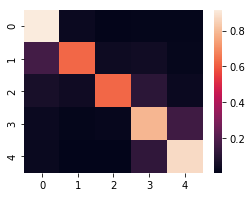

In [65]:
night = processed_df[processed_df['typeB'] == 1]
fastfood = processed_df[processed_df['typeB'] == 2]
breakfast = processed_df[processed_df['typeB'] == 3]
coffee = processed_df[processed_df['typeB'] == 4]
cafe = processed_df[processed_df['typeA'] == 5]
model_tester(model_night, cafe['review'], cafe['star'], visualization=True)

use the entire dataset to train the model.

Using the entire data set to train the model yield an accuracy score of about 76%. Applying this model to any of the categories...

In [67]:
all_data = full_model
all_data.fit(X_train.values.astype('U'), y_train)
y_pred = all_data.predict(X_test)
print('F1 score',f1_score(y_test, y_pred, average='macro'))
print('Accuracy', accuracy_score(y_test, y_pred))
print('Confusion: Matrix \n', confusion_matrix(y_test, y_pred))

F1 score 0.745670099971646
Accuracy 0.7602763385146805
Confusion: Matrix 
 [[2123  101   26   69   50]
 [ 378 1109  109  201  102]
 [ 156  105 1250  542  171]
 [  58   25   60 2839  765]
 [  45    7   11  489 3684]]


F1 score 0.9749722788917243
Accuracy 0.9754148814193471
Confusion: Matrix 
 [[14612    67    14    43    37]
 [  239 10972    61   119    68]
 [   98    65 11591   316    94]
 [   38    12    33 20638   426]
 [   20     2     8   277 23005]]


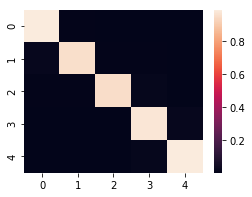

In [69]:
model_tester(all_data, night['review'], night['star'], visualization=True)

## Investigating the feature importance from the random forest classifier

In [70]:
#find out the top 100 words in terms of the importances to the classifier
def important_words(trained_model, top, bottom, output=False):
    importance = np.array(trained_model.named_steps['forest'].feature_importances_)
    idx_top = np.argpartition(importance, -top)[-top:]
    idx_bot = np.argpartition(importance, bottom)[:bottom]
    feature_names = np.array(all_data.named_steps['vectorizer'].get_feature_names())
    
    most_imp = feature_names[idx_top[np.argsort(importance[idx_top])[::-1]]]
    least_imp = feature_names[idx_bot[np.argsort(importance[idx_bot])]]
    
    print('%.0f Most important words:'%top, most_imp)
    print('%.0f Least important words:'%bottom, least_imp)
    
    if output == True:
        return most_imp, least_imp

In [71]:
most_imp, least_imp = important_words(all_data, 100, 100, output=True)

100 Most important words: ['great' 'good' 'amazing' 'delicious' 'best' 'food' 'worst' 'minutes'
 'asked' 'would' 'place' 'love' 'service' 'horrible' 'never' 'pretty'
 'like' 'friendly' 'definitely' 'terrible' 'bad' 'manager' 'awesome'
 'perfect' 'really' 'nice' 'back' 'rude' 'little' 'favorite' 'get'
 'nothing' 'told' 'one' 'us' 'time' 'excellent' 'go' 'menu' 'ordered'
 'even' 'also' 'better' 'said' 'bit' 'tasty' 'decent' 'always' 'order'
 'much' 'bar' 'try' 'could' 'fresh' 'ever' 'came' 'got' 'well' 'bland'
 'ok' 'restaurant' 'though' 'everything' 'however' 'overall' 'think'
 'chicken' 'went' 'come' 'people' 'staff' 'another' 'took' 'stars'
 'mediocre' 'drinks' 'first' 'okay' 'fantastic' 'waited' 'table' 'cheese'
 'loved' 'money' 'night' 'maybe' 'way' 'server' 'left' 'experience'
 'still' 'two' 'going' 'fries' 'know' 'made' 'eat' 'waitress' 'wait'
 'happy']
100 Least important words: ['explained' 'requested' 'recommendations' 'drink order' 'lime'
 'goat cheese' 'passed' 'toasted' 'med

After preliminary manual tagging of these words/bigrams, we can make two pie charts to compare the difference.

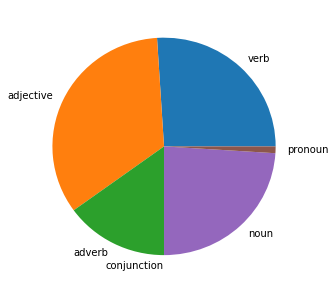

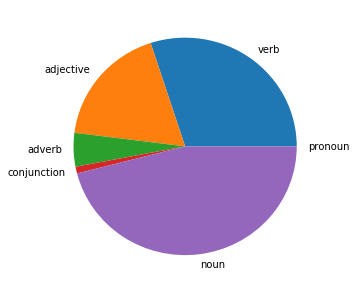

In [106]:
MI_cnt = [26, 34, 15, 0, 24, 1]
MI_lab = ['verb', 'adjective', 'adverb', 'conjunction', 'noun', 'pronoun']
LI_cnt = [30, 18, 5, 1, 46, 0]
LI_lab = ['verb', 'adjective', 'adverb', 'conjunction', 'noun', 'pronoun']

plt.figure(figsize=(5,5))
plt.pie(MI_cnt, labels=MI_lab)
plt.show()

plt.figure(figsize=(5,5))
plt.pie(LI_cnt, labels=LI_lab)
plt.show()

## Investigating where the model fails (tragically)

see where the model predict 1 star as 5 star or vice versa

When the prediction is significantly biased, the review are normally shorter

In [164]:
df_pred = pd.DataFrame({'review': X_test.values.astype('U'), 'TrueY': y_test, 'PredY': y_pred})
df_OneAsFive = df_pred.loc[(df_pred['TrueY'] == 1) & (df_pred['PredY'] == 5)]
df_FiveAsOne = df_pred.loc[(df_pred['TrueY'] == 5) & (df_pred['PredY'] == 1)]
df_threefour = df_pred.loc[(df_pred['TrueY'] == 3) & (df_pred['PredY'] == 4)]
df_correct = df_pred.loc[df_pred['TrueY'] == df_pred['PredY']]

In [160]:
#a function to calculate the average review length (No. of characters) 
def review_length(df):
    avg_len = 0
    for i in range(df.shape[0]):
        avg_len += len(df.iloc[i,0])
    avg_len = avg_len/df.shape[0]
    print(avg_len)

In [165]:
review_length(df_correct)
review_length(df_OneAsFive)
review_length(df_FiveAsOne)
review_length(df_threefour)

545.1506587914585
411.28
463.84444444444443
638.9169741697417


In [187]:
def top_tfidf(df, n):
    
    tfidf_vectorizer_diagnosis = TfidfVectorizer(analyzer='word', max_features=5000, min_df=0.01, max_df=0.95, ngram_range=(1,1))
    tfidf = tfidf_vectorizer_diagnosis.fit_transform(df['review'])
    feature_array = np.array(tfidf_vectorizer_diagnosis.get_feature_names())
    tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]
    
    return feature_array[tfidf_sorting][:n]

In [189]:
top_tfidf(df_FiveAsOne, 50)

array(['wrap', 'garlic', 'umph', 'ranch', 'mozzarella', 'encountered',
       'favor', 'add', 'give', 'chicken', 'get', 'gas', 'find', 'fingers',
       'finish', 'finished', 'fire', 'first', 'fit', 'flamer', 'flames',
       'flatbread', 'flavor', 'gentlemen', 'flavorful', 'flavors',
       'fleeing', 'flight', 'gentleman', 'flip', 'fine', 'finally',
       'food', 'filling', 'favorite', 'favorites', 'favourite', 'fbi',
       'feature', 'feel', 'feels', 'felix', 'fell', 'felt', 'fettuccini',
       'figure', 'german', 'figured', 'file', 'filed'], dtype='<U14')

In [190]:
top_tfidf(df_OneAsFive, 50)

array(['service', 'may', 'come', 'wave', 'refill', 'aimlessly', 'box',
       'waited', 'seen', 'watching', 'great', 'portion', 'walking',
       'stars', 'problem', 'overall', 'tv', 'size', 'main', 'hostess',
       'mediocre', 'plenty', 'forever', 'food', 'happy', 'water', 'price',
       'hour', 'busy', 'still', 'delicious', 'experience', 'us', 'good',
       'best', 'time', 'get', 'experiencing', 'failure', 'family',
       'everyone', 'everything', 'everywhere', 'false', 'exam', 'fake',
       'excellent', 'excited', 'failures', 'execution'], dtype='<U14')

## Try to calculate the similarity of all 1 star review among different cuisines or retaurant types

In [206]:
tfidf = TfidfVectorizer().fit_transform(all_reviews.values.astype('U'))

In [224]:
#1 star
def calculate_cosine_similarity(star):
    documents = []
    for i in range(1, 7):
        s = ''
        all_reviews = processed_df.loc[(processed_df['typeA'] == i) & (processed_df['star'] == star)].loc[:,'review']
        for r in all_reviews.values.astype('U'):
            s += r
        documents.append(s)
    tfidf = TfidfVectorizer().fit_transform(documents)
    pairwise_similarity = tfidf * tfidf.T
    pairwise_similarity = pairwise_similarity.toarray()
    
    plt.figure(figsize=(5,5))
    sns.heatmap(pairwise_similarity)
    plt.show()
    
    return pairwise_similarity

In [226]:
idA

{1: 'American (Traditional)',
 2: 'Italian',
 3: 'Mexican',
 4: 'Chinese',
 5: 'American (New)',
 6: 'Japanese',
 0: 'Other'}

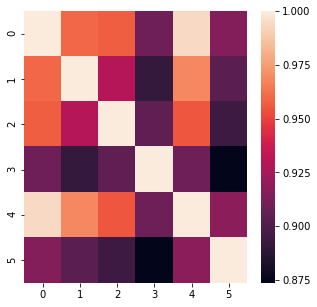

In [225]:
cosine_sim_1star = calculate_cosine_similarity(1)

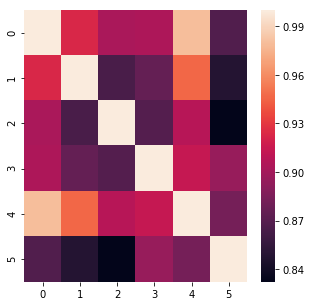

In [227]:
cosine_sim_5star = calculate_cosine_similarity(5)

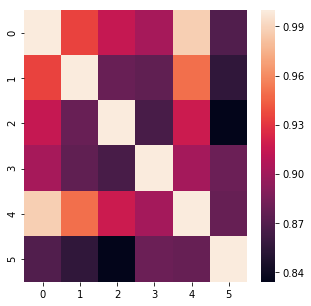

In [228]:
cosine_sim_3star = calculate_cosine_similarity(3)